Enlazamos Drive para obtener las imagenes de entrenamiento y testeo, además del modelo que creamos

In [1]:
from google.colab import drive

# Ruta para trabajar desde drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/Datasets/img_align_celeba.zip

Cargamos el modelo creado

In [5]:
from tensorflow.keras.models import load_model
from keras.api._v2.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

modeloc=load_model('/content/drive/MyDrive/Datasets/caras_checkpoints.h5')
modeloc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 178, 178, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 178, 178, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 128)       5

Aquí empezamos a hacer un fine-tunning.
En este caso, quitamos las últimas 3 capas de la red creada, encargadas de realizar a clasificación de las características de la imagen (las capas densas).

una vez seleccionadas las capas que queremos, congelamos las primeras capas, y dejamos disponibles para entrenamiento el ultimo bloque de capa convolucional (Conv2D, batchnormalization, activación, maxpooling)

Estas capas las guardamos en un nuevo modelo secuencial, agregandole un bloque convoluciónal nuevo (sin max pooling)

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.api._v2.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

modeloc.trainable=True
modeloc_capas=Sequential()
i=0
for capas in modeloc.layers[:-3]:
  if i <12:
    capas.trainable=False
    modeloc_capas.add(capas)
  else:
    modeloc_capas.add(capas)
  i+=1
modeloc_capas.add(Conv2D(128,(3,3),name='agregadaconv'))
modeloc_capas.add(Activation('relu',name='agregadoact'))
modeloc_capas.add(BatchNormalization( name='agregadobn'))
modeloc_capas.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 178, 178, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 178, 178, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 128)      

Ocupé este bloque de código para guardar algunas imagenes de la base de datos de celebA, el mismo número que las imagenes que me tomé con mi celular (112 para training y 112 para test)

In [4]:
import os
import shutil

# Ruta de la carpeta de origen
carpeta_origen = "/content/img_align_celeba"

# Ruta de la carpeta de destino
carpeta_destino_tr = "/content/Caras/Train/Celab"
carpeta_destino_ts = "/content/Caras/Test/Celab"


# Obtener la lista de archivos en la carpeta de origen
archivos = os.listdir(carpeta_origen)

# Filtrar solo archivos JPG
imagenes_jpg = [archivo for archivo in archivos if archivo.lower().endswith(".jpg")]

# Ordenar las imágenes por fecha de modificación (últimas primero)
imagenes_jpg.sort(key=lambda x: os.path.getmtime(os.path.join(carpeta_origen, x)), reverse=True)

# Seleccionar las últimas 112 imágenes
ultimas_imagenes = imagenes_jpg[:224]

# Mover las imágenes seleccionadas a la carpeta de destino
i=1
for imagen in ultimas_imagenes:
    origen = os.path.join(carpeta_origen, imagen)
    if i<=112:
      destino = os.path.join(carpeta_destino_tr, imagen)
    else:
      destino= os.path.join(carpeta_destino_ts, imagen)
    shutil.move(origen, destino)
    i+=1


Guardamos las imagenes en las estructuras de los datasets para manejarlos dentro del código

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

gentrain = ImageDataGenerator(rescale=1. / 255., #indica que reescale cada canal con valor entre 0 y 1.
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

gentest = ImageDataGenerator(rescale=1./255.)

train = gentrain.flow_from_directory('/content/drive/MyDrive/Datasets/Caras/Train',
                batch_size=23,
                target_size=(180, 180),
                class_mode='binary')

test = gentest.flow_from_directory('/content/drive/MyDrive/Datasets/Caras/Test',
                batch_size=23,
                target_size=(180, 180),
                class_mode='binary')

Found 224 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


Creamos una nueva arquitectura de red, usando las capas convolucionales de la red que acabamos de guardar en el nuevo modelo de capas, agregandole un clasificador para determinar si existe mi cara en a imagen que se va a procesar.

In [27]:
inputs= keras.Input(shape=(180,180,3))
x=modeloc_capas(inputs)
x=Flatten()(x)
x=Dense(512)(x)
outputs =Dense(1,activation='sigmoid')(x)
modelcar2= keras.Model(inputs,outputs)
modelcar2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 7, 7, 128)         2145280   
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               3211776   
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 5357569 (20.44 MB)
Trainable params: 4983681 (19.01 MB)
Non-trainable params: 373888 (1.43 MB)
_________________________________________________________________


In [ ]:
checkpoint = callbacks.ModelCheckpoint('fc.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelcar2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

historial=modelcar2.fit(train, epochs=30, validation_data=test, verbose=1, callbacks=[checkpoint] )

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8705
Epoch 1: val_loss improved from inf to 0.59556, saving model to fc.hdf5
10/10 [==============================] - 85s 9s/step - loss: 0.4759 - accuracy: 0.8705 - val_loss: 0.5956 - val_accuracy: 0.6920
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9062
Epoch 2: val_loss did not improve from 0.59556
10/10 [==============================] - 81s 8s/step - loss: 0.2502 - accuracy: 0.9062 - val_loss: 0.6323 - val_accuracy: 0.6295
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8705
Epoch 3: val_loss did not improve from 0.59556
10/10 [==============================] - 81s 8s/step - loss: 0.3557 - accuracy: 0.8705 - val_loss: 0.7532 - val_accuracy: 0.5893
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9018
Epoch 4: val_loss did not improve from 0.59556
10/10 [=================

Al parecer, con los parámetros elegidos para este entrenamiento, hubo un mal resultado en el costo de la validación (aunque cercano a 0)

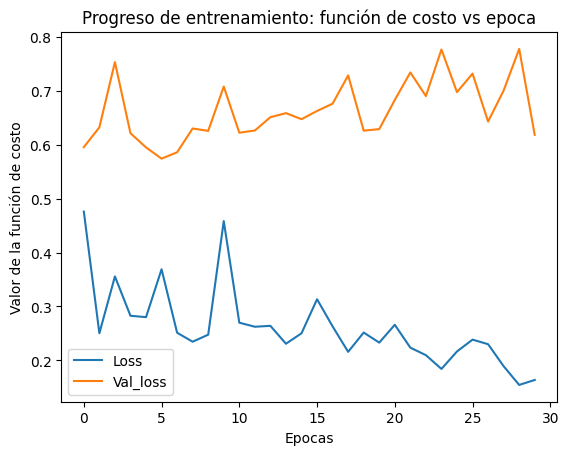

In [37]:
import matplotlib.pyplot as plt
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Progreso de entrenamiento: función de costo vs epoca')
plt.xlabel('Epocas')
plt.ylabel('Valor de la función de costo')
plt.legend(['Loss','Val_loss'])

Para este entrenamiento, probé aumentar el número de epocas, ademas de una capa dropout de 0.2, logrando mejores resultados

In [47]:
inputs= keras.Input(shape=(180,180,3))
x=modeloc_capas(inputs)
x=Flatten()(x)
x=Dense(512)(x)
x=Dropout(0.2)(x)
outputs =Dense(1,activation='sigmoid')(x)
modelcar2= keras.Model(inputs,outputs)
modelcar2.summary()

checkpoint = callbacks.ModelCheckpoint('fc.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelcar2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

historial=modelcar2.fit(train, epochs=60, validation_data=test, verbose=1, callbacks=[checkpoint] )

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 7, 7, 128)         2145280   
                                                                 
 flatten_11 (Flatten)        (None, 6272)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               3211776   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 5357569 (20.44 MB)
Trainable params: 4983681

Al parecer en la gráfica, el valor de la función de costo de la validación se mantiene rondando el valor 0.6

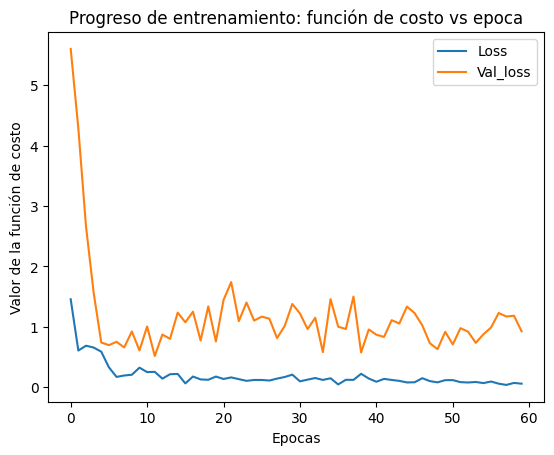

In [48]:
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Progreso de entrenamiento: función de costo vs epoca')
plt.xlabel('Epocas')
plt.ylabel('Valor de la función de costo')
plt.legend(['Loss','Val_loss'])

Probamos que funcione la red

In [64]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

a=Image.open('/content/drive/MyDrive/Datasets/Caras/Test/Celab_ts/202347.jpg').resize((180,180))
a=image.img_to_array(a)
a=preprocess_input(a.reshape(1,180,180,3))
a=modelcar2.predict(a)
#respuestas=[round(x) for x in a]
respuestas=a
print(respuestas)

1/1 [==============================] - 0s 156ms/step
[[0.]]
